# Documentation of Experiments to Accompany "How to Solve the Problem of Imbalanced Datasets: Meet Tonic Data Science Mode" Blog Post

*NB: This notebook was run separately from the one referenced in the blog post - numbers from distribution analysis may differ slightly*

In [3]:
#importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import xgboost as xgb
#may need to install catboost
!pip install catboost
from catboost import CatBoostClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score

from imblearn.over_sampling import SMOTE, SMOTENC

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings("ignore")

xgb.verbosity = 0

## Data Import and Cleaning

In [2]:
#value counts and percentages of churn from the raw data
raw = pd.read_csv('telco.csv', low_memory=False)
print('Churn value counts:')
print(raw['Churn'].value_counts())
print('\nChurn percentages:')
print(round((raw['Churn'].value_counts()/raw.shape[0])*100, 2))

Churn value counts:
No     5174
Yes    1869
Name: Churn, dtype: int64

Churn percentages:
No     73.46
Yes    26.54
Name: Churn, dtype: float64


In [3]:
#checking data for cleanliness
n_values = raw.nunique()
dtype = raw.dtypes
null_cnt = raw.isna().sum()
null_pct = raw.isna().sum()/raw.shape[0]
info = pd.concat([n_values, dtype, null_cnt, null_pct], axis=1)
info.columns = ['n_values', 'dtype', 'null_cnt', 'null_pct']
info

,n_values,dtype,null_cnt,null_pct
customerID,7043,object,0,0.0
gender,2,object,0,0.0
SeniorCitizen,2,int64,0,0.0
Partner,2,object,0,0.0
Dependents,2,object,0,0.0
tenure,73,int64,0,0.0
PhoneService,2,object,0,0.0
MultipleLines,3,object,0,0.0
InternetService,3,object,0,0.0
OnlineSecurity,3,object,0,0.0


In [4]:
#cleaning and splitting data
raw_cleaned = raw.copy()

def clean_total_charges(x):
    try:
        return float(x)
    except:
        return np.nan

raw_cleaned['TotalCharges'] = raw['TotalCharges'].apply(clean_total_charges)

#dropping rows with NaNs
data_cleaned = raw_cleaned.dropna().reset_index(drop=True)

## Modeling prep

In [5]:
#splitting and saving data 
random_state = 0
data_train, data_test = train_test_split(data_cleaned, test_size=0.25, random_state=random_state)
 
data_train.to_csv('telco_train.csv', index=False)
data_test.to_csv('telco_test.csv', index=False)

In [8]:
#reading test/train data previously split in data
data_train = pd.read_csv('telco_train.csv')
data_test = pd.read_csv('telco_test.csv')

In [9]:
#defining inputs and outputs
target = 'Churn'
modeling_columns = [x for x in data_train.columns if x != 'customerID']

In [10]:
#defining columns to encode
categorical_columns = [x for x in modeling_columns if data_train[x].dtype == 'object']
input_columns = [x for x in modeling_columns if x != target]

In [11]:
#defining the features of the data
X = data_train[input_columns].copy()

#instatiating encoder
feature_dimensions_X = []
for col in X.columns:
    if col in categorical_columns:
        feature_dimensions_X.append(X[col].nunique())
    else:
        feature_dimensions_X.append(1)

column_to_one_hot_encoder = {}
for col in X.columns:
    if col in categorical_columns:
        #instatiating the encoder
        encoder = OneHotEncoder(sparse=False)
        #training the encoder
        encoder.fit(X[[col]])
        column_to_one_hot_encoder[col] = encoder

In [12]:
#defining one hot encoder function
def one_hot_encode(data, column_to_one_hot_encoder):
    categorical_columns = list(column_to_one_hot_encoder.keys())
    oh_encoded_list = []
    for col in data.columns:
        if col in categorical_columns:
            encoder = column_to_one_hot_encoder[col]
            #implementing the encoder
            col_ohe = encoder.transform(data[[col]])
            ohe_column_names = [col + '_' + x for x in list(encoder.categories_[0])]
            col_ohe_df = pd.DataFrame(col_ohe, columns=ohe_column_names)
            oh_encoded_list.append(col_ohe_df)
        else:
            oh_encoded_list.append(data[[col]].reset_index(drop=True))
    
    data_oh_encoded = pd.concat(oh_encoded_list, axis=1)
    return data_oh_encoded

In [13]:
#defining and transforming test and train datasets using the above function
#defining test and train dataframes
X_train = data_train[input_columns].copy()
X_test = data_test[input_columns].copy()

y_train = data_train[target].copy()
y_test = data_test[target].copy()

#encoding churn column for modeling
y_train_encoded = y_train.apply(lambda x : int(x == 'Yes'))
y_test_encoded = y_test.apply(lambda x : int(x == 'Yes'))

#onehot encoding inputs
X_train_oh_encoded = one_hot_encode(X_train, column_to_one_hot_encoder)
X_test_oh_encoded = one_hot_encode(X_test, column_to_one_hot_encoder)

In [14]:
#defining models
log_reg = LogisticRegression(random_state=7001)
xgb_class = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=7001)
catboost = CatBoostClassifier(silent=True, random_state=7001)

## Modeling on Imbalanced Dataset

In [15]:
#running models and defining predictions - will use these later to evaluate individual models

#log reg
#model
unaug_log_reg = log_reg.fit(X_train_oh_encoded, y_train_encoded)
#y proba predictions
unaug_log_reg_pred_proba = unaug_log_reg.predict_proba(X_test_oh_encoded)[:,1]
#y predictions 
unaug_log_reg_pred = unaug_log_reg.predict(X_test_oh_encoded)

#xgb
#model
unaug_xgb = xgb_class.fit(X_train_oh_encoded, y_train_encoded)
#y proba predictions
unaug_xgb_pred_proba = unaug_xgb.predict_proba(X_test_oh_encoded)[:,1]
#y predictions 
unaug_xgb_pred = unaug_xgb.predict(X_test_oh_encoded)

#catb
#dropping churn from categorical columns
#categorical_columns.remove('Churn')
#model
unaug_catboost = catboost.fit(X_train, y_train_encoded, cat_features=[col for col in categorical_columns if col!=target])
#y proba predictions
unaug_catboost_pred_proba = unaug_catboost.predict_proba(X_test)[:,1]
#y predictions
unaug_catboost_pred = unaug_catboost.predict(X_test)

In [16]:
#scoring models 
print('Baseline ROC AUC scores modeling with imbalanced data: \n')
print(f'Logistic Regression Baseline ROC AUC: {(roc_auc_score(y_test_encoded, unaug_log_reg_pred_proba))}')
print(f'XGBoost Baseline ROC AUC: {(roc_auc_score(y_test_encoded, unaug_xgb_pred_proba))}')
print(f'CatBoost Baseline ROC AUC: {(roc_auc_score(y_test_encoded, unaug_catboost_pred_proba))}')

print('\n Baseline F1 scores modeling with imbalanced data: \n')
print(f"Logistic F1: {f1_score(y_test_encoded, unaug_log_reg_pred)}")
print(f"XGBoost F1: {f1_score(y_test_encoded, unaug_xgb_pred)}")
print(f"CatBoost F1: {f1_score(y_test_encoded, unaug_catboost_pred)}")

Baseline ROC AUC scores modeling with imbalanced data: 

Logistic Regression Baseline ROC AUC: 0.8358537380314905
XGBoost Baseline ROC AUC: 0.816745077361237
CatBoost Baseline ROC AUC: 0.8404286906352546

 Baseline F1 scores modeling with imbalanced data: 

Logistic F1: 0.5854858548585485
XGBoost F1: 0.5247524752475248
CatBoost F1: 0.5717884130982368


In [17]:
#defining function to get a confusion matrix heatmap 
def cf_matrix_plot(y_test, y_pred, axes):
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
    cf_heatmap = sns.heatmap(cf_matrix, annot=True, cmap="BuPu", fmt='g', ax=axes)
    
    return cf_heatmap

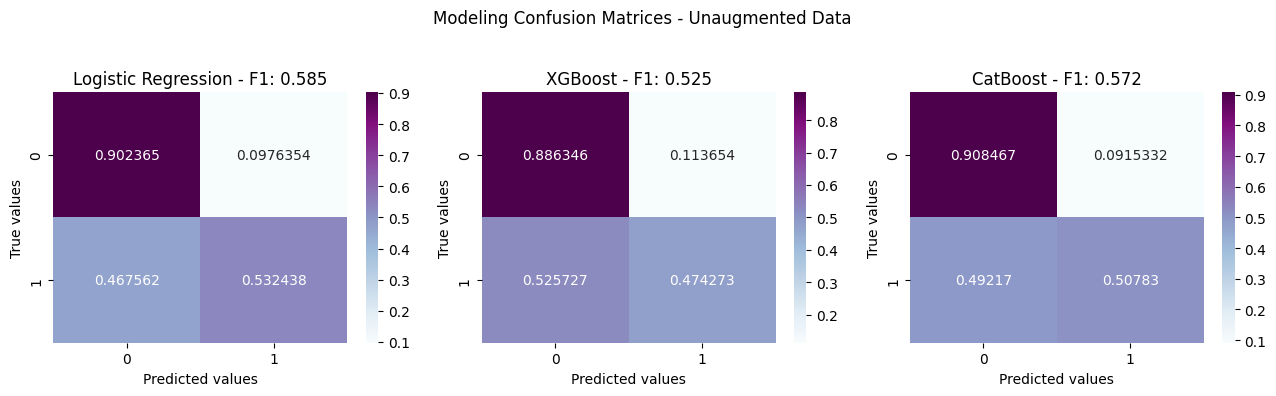

In [27]:
#subplot of confusion matricies
unaug_fig, axes= plt.subplots(1,3, figsize=(13,4))
axes = axes.flatten()
unaug_fig.suptitle('Modeling Confusion Matrices - Unaugmented Data \n')

cf_matrix_plot(y_test_encoded, unaug_log_reg_pred, axes[0])
axes[0].set_title(f"Logistic Regression - F1: {round(f1_score(y_test_encoded, unaug_log_reg_pred),3)}")
axes[0].set_ylabel('True values')
axes[0].set_xlabel('Predicted values')

cf_matrix_plot(y_test_encoded, unaug_xgb_pred, axes[1])
axes[1].set_title(f"XGBoost - F1: {round(f1_score(y_test_encoded, unaug_xgb_pred), 3)}")
axes[1].set_ylabel('True values')
axes[1].set_xlabel('Predicted values')

cf_matrix_plot(y_test_encoded, unaug_catboost_pred, axes[2])
axes[2].set_title(f"CatBoost - F1: {round(f1_score(y_test_encoded, unaug_catboost_pred), 3)}")
axes[2].set_ylabel('True values')
axes[2].set_xlabel('Predicted values')

unaug_fig.tight_layout()
plt.savefig('unaug_confusion_matrices_accomp.jpeg')
plt.show()

## Modeling with Tonic Data Science Mode (DSM) - synthesized data

In [22]:
#install the tonic api 
#!pip install tonic-api

#connecting to DSM
from tonic_api.api import TonicApi

api_token = "<APITOKEN"
workspace_id = "<WORKSPACEID>"
job_id = "<JOBID>"

tonic = TonicApi("https://djinn.tonic.ai", api_token)

#connecting to the workspace and model for this specific dataset
workspace = tonic.get_workspace(workspace_id)
model = workspace.get_trained_model_by_training_job_id(job_id)

In [23]:
#calculating the number of samples needed to balance the data
n_samples = data_train.shape[0]
n_churn = data_train[data_train['Churn'] == 'Yes'].shape[0]
n_samples_needed = int((0.5 * n_samples - n_churn) / (1 - 0.5)) + 1 

print(f'{n_samples_needed} synthetic data points are needed to balance the dataset 50/50.')

2431 synthetic data points are needed to balance the dataset 50/50.


In [24]:
#iterating through the modeling and scoring process 100x to get a range of results to observe scoring distribution
#instantiating lists of resulting scores
DSM_log_reg_roc_auc = []
DSM_xgb_roc_auc = []
DSM_catboost_roc_auc = []

DSM_log_reg_f_1 = []
DSM_xgb_f_1 = []
DSM_catboost_f_1 = []

for i in range(100):

    #pulling in 100,000 synthetic data points from DSM
    sample = model.sample(100000)
    churn_samples = sample[sample['Churn'] == 'Yes']

    #pulling out the number of minority class samples needed
    new_samples = churn_samples[:n_samples_needed]
    original_samples = data_train[modeling_columns].copy()
    #adding our synthetic data to our original training data
    new_model_train_data = pd.concat([original_samples, new_samples], axis=0).reset_index(drop=True)

    #encoding augmented data
    X_train_aug_encoded = one_hot_encode(new_model_train_data[input_columns], column_to_one_hot_encoder)
    #making SeniorCitizen an float since it got skipped over
    X_train_aug_encoded['SeniorCitizen']=X_train_aug_encoded['SeniorCitizen'].astype(float)
    y_aug_train_encoded = new_model_train_data[target].apply(lambda x: int(x == 'Yes'))

    #running models 
    #DSM
    #log reg
        #model
    DSM_log_reg = log_reg.fit(X_train_aug_encoded, y_aug_train_encoded)
        #y proba predictions
    DSM_log_reg_pred_proba = DSM_log_reg.predict_proba(X_test_oh_encoded)[:,1]
        #y predictions 
    DSM_log_reg_pred = DSM_log_reg.predict(X_test_oh_encoded)

    #xgb
        #model
    DSM_xgb = xgb_class.fit(X_train_aug_encoded, y_aug_train_encoded)
        #y proba predictions
    DSM_xgb_pred_proba = DSM_xgb.predict_proba(X_test_oh_encoded)[:,1]
        #y predictions 
    DSM_xgb_pred = DSM_xgb.predict(X_test_oh_encoded)

    #catb
    X_train_aug = new_model_train_data[input_columns]
        #model
    DSM_catboost = catboost.fit(X_train_aug, y_aug_train_encoded, cat_features=[col for col in categorical_columns if col!=target])
      #y proba predictions
    DSM_catboost_pred_proba = unaug_catboost.predict_proba(X_test)[:,1]
      #y predictions
    DSM_catboost_pred = unaug_catboost.predict(X_test)

    #score the models 
    DSM_log_reg_roc_auc.append(roc_auc_score(y_test_encoded, DSM_log_reg_pred_proba))
    DSM_log_reg_f_1.append(roc_auc_score(y_test_encoded, DSM_log_reg_pred))

    DSM_xgb_roc_auc.append(roc_auc_score(y_test_encoded, DSM_xgb_pred_proba))
    DSM_xgb_f_1.append(roc_auc_score(y_test_encoded, DSM_xgb_pred))

    DSM_catboost_roc_auc.append(roc_auc_score(y_test_encoded, DSM_catboost_pred_proba))
    DSM_catboost_f_1.append(roc_auc_score(y_test_encoded, DSM_catboost_pred))
    
    print(f"{i+1} iterations complete.")

1 iterations complete.
2 iterations complete.
3 iterations complete.
4 iterations complete.
5 iterations complete.
6 iterations complete.
7 iterations complete.
8 iterations complete.
9 iterations complete.
10 iterations complete.
11 iterations complete.
12 iterations complete.
13 iterations complete.
14 iterations complete.
15 iterations complete.
16 iterations complete.
17 iterations complete.
18 iterations complete.
19 iterations complete.
20 iterations complete.
21 iterations complete.
22 iterations complete.
23 iterations complete.
24 iterations complete.
25 iterations complete.
26 iterations complete.
27 iterations complete.
28 iterations complete.
29 iterations complete.
30 iterations complete.
31 iterations complete.
32 iterations complete.
33 iterations complete.
34 iterations complete.
35 iterations complete.
36 iterations complete.
37 iterations complete.
38 iterations complete.
39 iterations complete.
40 iterations complete.
41 iterations complete.
42 iterations complete.
4

In [20]:
#saving all scores as a dataframe
DSM_log_reg_roc_auc_df = pd.DataFrame(DSM_log_reg_roc_auc, columns=['log_reg_roc_auc'])
DSM_xgb_roc_auc_df = pd.DataFrame(DSM_xgb_roc_auc, columns=['xgb_roc_auc'])
DSM_catboost_roc_auc_df = pd.DataFrame(DSM_catboost_roc_auc, columns=['catboost_roc_auc'])

DSM_log_reg_f_1_df = pd.DataFrame(DSM_log_reg_f_1, columns=['log_reg_f_1'])
DSM_xgb_f_1_df = pd.DataFrame(DSM_xgb_f_1, columns=['xgb_f_1'])
DSM_catboost_f_1_df = pd.DataFrame(DSM_catboost_f_1, columns=['catboost_f_1'])

DSM_dfs = [DSM_log_reg_roc_auc_df, DSM_xgb_roc_auc_df, DSM_catboost_roc_auc_df, DSM_log_reg_f_1_df, DSM_xgb_f_1_df, DSM_catboost_f_1_df]
DSM_scores = pd.concat(DSM_dfs, axis=1)

#saving scores as a csv
DSM_scores.to_csv('DSM_scores_accomp.csv')

In [21]:
#loading saved DSM scores
DSM_scores = pd.read_csv('DSM_scores_accomp.csv', index_col=0)
DSM_scores.head()

,log_reg_roc_auc,xgb_roc_auc,catboost_roc_auc,log_reg_f_1,xgb_f_1,catboost_f_1
0,0.833973,0.819379,0.845538,0.755699,0.740298,0.759313
1,0.834613,0.826723,0.843180,0.756715,0.751204,0.763025
2,0.835787,0.821356,0.845381,0.760580,0.741467,0.751788
3,0.834200,0.823340,0.845268,0.753895,0.730891,0.761957
4,0.834746,0.829999,0.845396,0.756894,0.747874,0.764804


In [22]:
#results 
DSM_scores.describe()

,log_reg_roc_auc,xgb_roc_auc,catboost_roc_auc,log_reg_f_1,xgb_f_1,catboost_f_1
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.834862,0.824836,0.845948,0.758285,0.741009,0.759538
std,0.000936,0.003504,0.001350,0.002726,0.005744,0.004545
min,0.832299,0.815871,0.842024,0.751225,0.725679,0.746551
25%,0.834300,0.822435,0.845262,0.756360,0.737209,0.757044
50%,0.834816,0.824619,0.845942,0.758051,0.740717,0.759618
75%,0.835443,0.827521,0.846903,0.759901,0.744880,0.762999
max,0.837533,0.833289,0.849591,0.764776,0.755576,0.768313


## Modeling with SMOTE and SMOTE-NC

### SMOTE

In [23]:
#iterating through modeling and scoring 100x to account for randomness in SMOTE and look at the distribution
#instantiating lists of scores 
SMOTE_log_reg_roc_auc = []
SMOTE_xgb_roc_auc = []
SMOTE_catboost_roc_auc = []

SMOTE_log_reg_f_1 = []
SMOTE_xgb_f_1 = []
SMOTE_catboost_f_1 = []

#iterating
for i in range(100):

    #augmenting data with SMOTE
    X_train_oh_encoded_smoted, y_train_encoded_smoted = SMOTE().fit_resample(X_train_oh_encoded, y_train_encoded)

    #running models
    #log reg
        #model
    smote_log_reg = log_reg.fit(X_train_oh_encoded_smoted, y_train_encoded_smoted)
        #y proba predictions
    smote_log_reg_pred_proba = smote_log_reg.predict_proba(X_test_oh_encoded)[:,1]
        #y predictions 
    smote_log_reg_pred = smote_log_reg.predict(X_test_oh_encoded)

    #xgb
        #model
    smote_xgb = xgb_class.fit(
        np.array(X_train_oh_encoded_smoted), 
        np.array(y_train_encoded_smoted))
        #y proba predictions
    smote_xgb_pred_proba = smote_xgb.predict_proba(
        np.array(X_test_oh_encoded))[:,1]
        #y predictions 
    smote_xgb_pred = smote_xgb.predict(
        np.array(X_test_oh_encoded))

    #catb
        #model
    smote_catboost = catboost.fit(X_train_oh_encoded_smoted, y_train_encoded_smoted)
        #y proba predictions
    smote_catboost_pred_proba = smote_catboost.predict_proba(X_test_oh_encoded)[:,1]
        #y predictions 
    smote_catboost_pred = smote_catboost.predict(X_test_oh_encoded)

    #scoring models
    SMOTE_log_reg_roc_auc.append(roc_auc_score(y_test_encoded, smote_log_reg_pred_proba))
    SMOTE_log_reg_f_1.append(roc_auc_score(y_test_encoded, smote_log_reg_pred))

    SMOTE_xgb_roc_auc.append(roc_auc_score(y_test_encoded, smote_xgb_pred_proba))
    SMOTE_xgb_f_1.append(roc_auc_score(y_test_encoded, smote_xgb_pred))

    SMOTE_catboost_roc_auc.append(roc_auc_score(y_test_encoded, smote_catboost_pred_proba))
    SMOTE_catboost_f_1.append(roc_auc_score(y_test_encoded, smote_catboost_pred))

    print(f"{i+1} iterations complete.")

1 iterations complete.
2 iterations complete.
3 iterations complete.
4 iterations complete.
5 iterations complete.
6 iterations complete.
7 iterations complete.
8 iterations complete.
9 iterations complete.
10 iterations complete.
11 iterations complete.
12 iterations complete.
13 iterations complete.
14 iterations complete.
15 iterations complete.
16 iterations complete.
17 iterations complete.
18 iterations complete.
19 iterations complete.
20 iterations complete.
21 iterations complete.
22 iterations complete.
23 iterations complete.
24 iterations complete.
25 iterations complete.
26 iterations complete.
27 iterations complete.
28 iterations complete.
29 iterations complete.
30 iterations complete.
31 iterations complete.
32 iterations complete.
33 iterations complete.
34 iterations complete.
35 iterations complete.
36 iterations complete.
37 iterations complete.
38 iterations complete.
39 iterations complete.
40 iterations complete.
41 iterations complete.
42 iterations complete.
4

In [24]:
#saving all scores as a dataframe
SMOTE_log_reg_roc_auc_df = pd.DataFrame(SMOTE_log_reg_roc_auc, columns=['log_reg_roc_auc'])
SMOTE_xgb_roc_auc_df = pd.DataFrame(SMOTE_xgb_roc_auc, columns=['xgb_roc_auc'])
SMOTE_catboost_roc_auc_df = pd.DataFrame(SMOTE_catboost_roc_auc, columns=['catboost_roc_auc'])

SMOTE_log_reg_f_1_df = pd.DataFrame(SMOTE_log_reg_f_1, columns=['log_reg_f_1'])
SMOTE_xgb_f_1_df = pd.DataFrame(SMOTE_xgb_f_1, columns=['xgb_f_1'])
SMOTE_catboost_f_1_df = pd.DataFrame(SMOTE_catboost_f_1, columns=['catboost_f_1'])

SMOTE_dfs = [SMOTE_log_reg_roc_auc_df, SMOTE_xgb_roc_auc_df, SMOTE_catboost_roc_auc_df, SMOTE_log_reg_f_1_df, SMOTE_xgb_f_1_df, SMOTE_catboost_f_1_df]
SMOTE_scores = pd.concat(SMOTE_dfs, axis=1)

#saving scores as a CSV
SMOTE_scores.to_csv('SMOTE_scores_accomp.csv')

In [25]:
#loading saved SMOTE scores
SMOTE_scores = pd.read_csv('SMOTE_scores_accomp.csv', index_col=0)
SMOTE_scores.head()

,log_reg_roc_auc,xgb_roc_auc,catboost_roc_auc,log_reg_f_1,xgb_f_1,catboost_f_1
0,0.834644,0.818818,0.832924,0.758192,0.705630,0.713943
1,0.832635,0.819938,0.831937,0.755981,0.696681,0.703088
2,0.835041,0.818962,0.834047,0.759362,0.701537,0.713943
3,0.836977,0.823315,0.832789,0.768692,0.704486,0.713969
4,0.833158,0.820852,0.833642,0.759692,0.701460,0.710181


In [26]:
#results
SMOTE_scores.describe()

,log_reg_roc_auc,xgb_roc_auc,catboost_roc_auc,log_reg_f_1,xgb_f_1,catboost_f_1
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.835332,0.821945,0.832473,0.761509,0.706448,0.709815
std,0.000975,0.002728,0.001068,0.003639,0.005512,0.004676
min,0.832635,0.816550,0.829499,0.753260,0.691444,0.699402
25%,0.834710,0.819875,0.831836,0.759260,0.702649,0.706463
50%,0.835322,0.821736,0.832540,0.761509,0.706583,0.709456
75%,0.836035,0.823700,0.833103,0.764516,0.710072,0.713549
max,0.837265,0.829109,0.835059,0.768692,0.725841,0.719815


### SMOTE-NC

In [27]:
#subsetting categorical columns
categorical_columns = list(column_to_one_hot_encoder.keys())
categorical_features = []
for col in X_train.columns:
    if col in categorical_columns:
        categorical_features.append(True)
    else:
        categorical_features.append(False)

In [28]:
#iterating through SMOTE-NC resampling 100x to account for randomness and evaluate on score distributions
#instantiating lists of resulting scores
SMOTE_NC_log_reg_roc_auc = []
SMOTE_NC_xgb_roc_auc = []
SMOTE_NC_catboost_roc_auc = []

SMOTE_NC_log_reg_f_1 = []
SMOTE_NC_xgb_f_1 = []
SMOTE_NC_catboost_f_1 = []

for i in range(100):
    
    #augmenting data with SMOTE-NC
    X_train_smotenced, y_train_smotenced = SMOTENC(
        categorical_features=np.array(categorical_features)
    ).fit_resample(X_train, y_train)

    #one hot encoding smotenced data
    X_train_oh_encoded_smotenced = one_hot_encode(X_train_smotenced, column_to_one_hot_encoder)
    y_train_encoded_smotenced = y_train_smotenced.apply(lambda x : int(x == 'Yes'))

    #Modeling smote-nced data
    #log reg
        #model
    smotenc_log_reg = log_reg.fit(X_train_oh_encoded_smotenced, y_train_encoded_smotenced)
        #y proba predictions
    smotenc_log_reg_pred_proba = smotenc_log_reg.predict_proba(X_test_oh_encoded)[:,1]
        #y predictions
    smotenc_log_reg_pred = smotenc_log_reg.predict(X_test_oh_encoded)

    #xgb
        #model
    smotenc_xgb = xgb_class.fit(
        np.array(X_train_oh_encoded_smotenced), 
        np.array(y_train_encoded_smotenced))
        #y proba predictions
    smotenc_xgb_pred_proba = smotenc_xgb.predict_proba(
        np.array(X_test_oh_encoded))[:,1]
        #y predictions 
    smotenc_xgb_pred = smotenc_xgb.predict(
        np.array(X_test_oh_encoded))
    #catb
        #model
    smotenc_catboost = catboost.fit(X_train_smotenced, y_train_encoded_smotenced, cat_features=[col for col in categorical_columns if col!=target])
        #y proba predictions
    smotenc_catboost_pred_proba = smotenc_catboost.predict_proba(X_test)[:,1]
        #y predictions 
    smotenc_catboost_pred = smotenc_catboost.predict(X_test)

    #scoring models
    SMOTE_NC_log_reg_roc_auc.append(roc_auc_score(y_test_encoded, smotenc_log_reg_pred_proba))
    SMOTE_NC_log_reg_f_1.append(roc_auc_score(y_test_encoded, smotenc_log_reg_pred))

    SMOTE_NC_xgb_roc_auc.append(roc_auc_score(y_test_encoded, smotenc_xgb_pred_proba))
    SMOTE_NC_xgb_f_1.append(roc_auc_score(y_test_encoded, smotenc_xgb_pred))

    SMOTE_NC_catboost_roc_auc.append(roc_auc_score(y_test_encoded, smotenc_catboost_pred_proba))
    SMOTE_NC_catboost_f_1.append(roc_auc_score(y_test_encoded, smotenc_catboost_pred))

    print(f"{i+1} iterations complete.")

1 iterations complete.
2 iterations complete.
3 iterations complete.
4 iterations complete.
5 iterations complete.
6 iterations complete.
7 iterations complete.
8 iterations complete.
9 iterations complete.
10 iterations complete.
11 iterations complete.
12 iterations complete.
13 iterations complete.
14 iterations complete.
15 iterations complete.
16 iterations complete.
17 iterations complete.
18 iterations complete.
19 iterations complete.
20 iterations complete.
21 iterations complete.
22 iterations complete.
23 iterations complete.
24 iterations complete.
25 iterations complete.
26 iterations complete.
27 iterations complete.
28 iterations complete.
29 iterations complete.
30 iterations complete.
31 iterations complete.
32 iterations complete.
33 iterations complete.
34 iterations complete.
35 iterations complete.
36 iterations complete.
37 iterations complete.
38 iterations complete.
39 iterations complete.
40 iterations complete.
41 iterations complete.
42 iterations complete.
4

In [31]:
#saving all scores as a dataframe
SMOTE_NC_log_reg_roc_auc_df = pd.DataFrame(SMOTE_NC_log_reg_roc_auc, columns=['log_reg_roc_auc'])
SMOTE_NC_xgb_roc_auc_df = pd.DataFrame(SMOTE_NC_xgb_roc_auc, columns=['xgb_roc_auc'])
SMOTE_NC_catboost_roc_auc_df = pd.DataFrame(SMOTE_NC_catboost_roc_auc, columns=['catboost_roc_auc'])

SMOTE_NC_log_reg_f_1_df = pd.DataFrame(SMOTE_NC_log_reg_f_1, columns=['log_reg_f_1'])
SMOTE_NC_xgb_f_1_df = pd.DataFrame(SMOTE_NC_xgb_f_1, columns=['xgb_f_1'])
SMOTE_NC_catboost_f_1_df = pd.DataFrame(SMOTE_NC_catboost_f_1, columns=['catboost_f_1'])

SMOTE_NC_dfs = [SMOTE_NC_log_reg_roc_auc_df, SMOTE_NC_xgb_roc_auc_df, SMOTE_NC_catboost_roc_auc_df, SMOTE_NC_log_reg_f_1_df, SMOTE_NC_xgb_f_1_df, SMOTE_NC_catboost_f_1_df]
SMOTE_NC_scores = pd.concat(SMOTE_NC_dfs, axis=1)

#saving scores as a CSV
SMOTE_NC_scores.to_csv('SMOTE_NC_scores_accomp.csv')

In [32]:
#loading SMOTE scores dataset
SMOTE_NC_scores = pd.read_csv('SMOTE_NC_scores_accomp.csv', index_col=0)
SMOTE_NC_scores.head()

,log_reg_roc_auc,xgb_roc_auc,catboost_roc_auc,log_reg_f_1,xgb_f_1,catboost_f_1
0,0.827874,0.813448,0.826228,0.757230,0.705855,0.718717
1,0.826619,0.815603,0.827801,0.756086,0.723422,0.728124
2,0.826953,0.811313,0.828496,0.755018,0.708829,0.721743
3,0.826386,0.819962,0.826794,0.750695,0.716710,0.723547
4,0.826593,0.813284,0.826050,0.750086,0.719303,0.723701


In [33]:
#results
SMOTE_NC_scores.describe()

,log_reg_roc_auc,xgb_roc_auc,catboost_roc_auc,log_reg_f_1,xgb_f_1,catboost_f_1
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.827298,0.815250,0.827261,0.752273,0.714635,0.724852
std,0.001142,0.002832,0.001238,0.002406,0.006124,0.004284
min,0.824557,0.807556,0.823600,0.747009,0.700643,0.714752
25%,0.826612,0.813597,0.826441,0.750651,0.709999,0.721736
50%,0.827311,0.815433,0.827362,0.752310,0.714587,0.724704
75%,0.827921,0.817247,0.827931,0.754108,0.718922,0.727368
max,0.829905,0.820515,0.829977,0.758195,0.731659,0.735598


## Comparing scores 

In [5]:
DSM_scores = pd.read_csv('djinn_scores_accomp.csv')
SMOTE_scores = pd.read_csv('SMOTE_scores_accomp.csv')
SMOTE_NC_scores = pd.read_csv('SMOTE_NC_scores_accomp.csv')

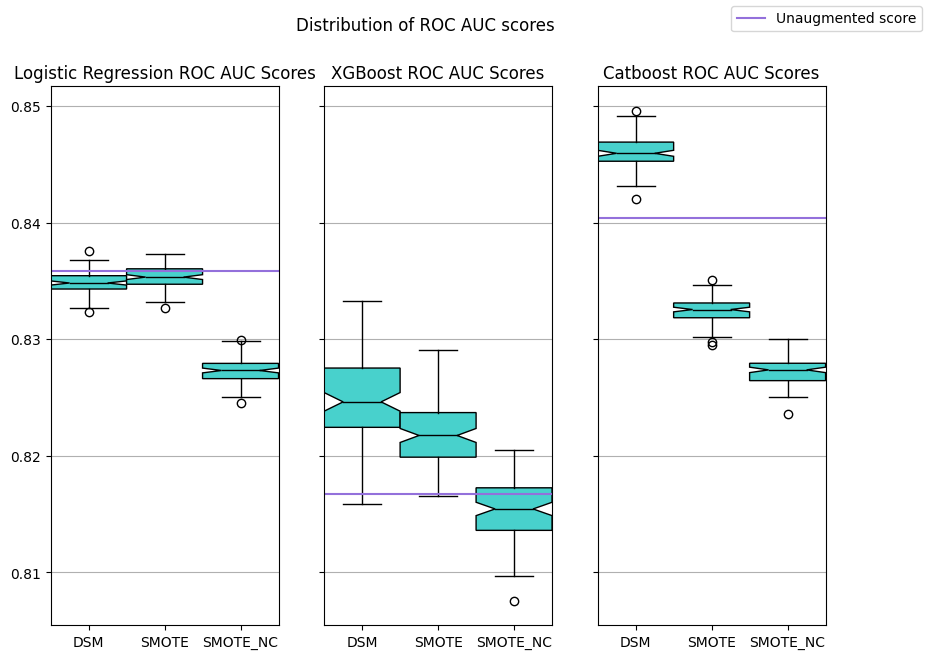

In [18]:
#distributions of ROC AUC scores for each model by augmentation method
roc_auc_fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,7), sharey=True)
roc_auc_fig.suptitle('Distribution of ROC AUC scores')

log_reg_box = [DSM_scores['log_reg_roc_auc'], SMOTE_scores['log_reg_roc_auc'], SMOTE_NC_scores['log_reg_roc_auc']]
xgb_box = [DSM_scores['xgb_roc_auc'], SMOTE_scores['xgb_roc_auc'], SMOTE_NC_scores['xgb_roc_auc']]
catboost_box= [DSM_scores['catboost_roc_auc'], SMOTE_scores['catboost_roc_auc'], SMOTE_NC_scores['catboost_roc_auc']]

bplot1 = ax1.boxplot(log_reg_box, patch_artist=True, notch=True, widths=1, medianprops={'color':'black'})
#changing color
for patch in bplot1['boxes']:
    patch.set_facecolor('mediumturquoise')
#other graph settings
ax1.set_xticks([1,2,3], ['DSM', 'SMOTE', 'SMOTE_NC'])
ax1.set_title('Logistic Regression ROC AUC Scores')
ax1.grid(axis='y')
ax1.axhline(roc_auc_score(y_test_encoded, unaug_log_reg_pred_proba), color='mediumpurple', label='Unaugmented score')

bplot2 = ax2.boxplot(xgb_box, patch_artist=True, notch=True, widths=1, medianprops={'color':'black'})
#changing color
for patch in bplot2['boxes']:
    patch.set_facecolor('mediumturquoise')
#other graph settings
ax2.set_xticks([1,2,3], ['DSM', 'SMOTE', 'SMOTE_NC'])
ax2.set_title('XGBoost ROC AUC Scores')
ax2.grid(axis='y')
ax2.axhline(roc_auc_score(y_test_encoded, unaug_xgb_pred_proba), color='mediumpurple')

bplot3 = ax3.boxplot(catboost_box, patch_artist=True, notch=True, widths=1, medianprops={'color':'black'})
#changing color
for patch in bplot3['boxes']:
    patch.set_facecolor('mediumturquoise')
#other graph settings
ax3.set_xticks([1,2,3], ['DSM', 'SMOTE', 'SMOTE_NC'])
ax3.set_title('Catboost ROC AUC Scores')
ax3.grid(axis='y')
ax3.axhline(roc_auc_score(y_test_encoded, unaug_catboost_pred_proba), color='mediumpurple')

roc_auc_fig.legend()

plt.savefig('roc_auc_box_accomp.jpeg')
plt.show()

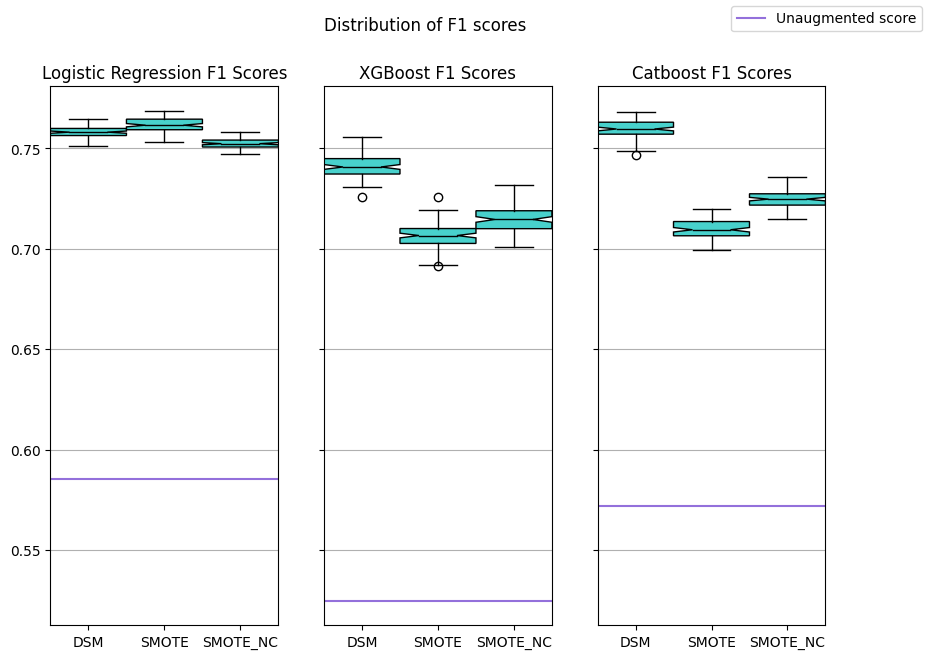

In [19]:
#distributions of F1 scores for each model by augmentation method
f_1_fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,7), sharey=True)
f_1_fig.suptitle('Distribution of F1 scores')

log_reg_box = [DSM_scores['log_reg_f_1'], SMOTE_scores['log_reg_f_1'], SMOTE_NC_scores['log_reg_f_1']]
xgb_box = [DSM_scores['xgb_f_1'], SMOTE_scores['xgb_f_1'], SMOTE_NC_scores['xgb_f_1']]
catboost_box= [DSM_scores['catboost_f_1'], SMOTE_scores['catboost_f_1'], SMOTE_NC_scores['catboost_f_1']]

bplot1 = ax1.boxplot(log_reg_box, patch_artist=True, notch=True, widths=1, medianprops={'color':'black'})
#set boxplot color
for patch in bplot1['boxes']:
    patch.set_facecolor('mediumturquoise')
#other graph settings
ax1.set_xticks([1,2,3], ['DSM', 'SMOTE', 'SMOTE_NC'])
ax1.set_title('Logistic Regression F1 Scores')
ax1.grid(axis='y')
ax1.axhline(f1_score(y_test_encoded, unaug_log_reg_pred), color='mediumpurple', label='Unaugmented score')

bplot2 = ax2.boxplot(xgb_box, patch_artist=True, notch=True, widths=1, medianprops={'color':'black'})
#set boxplot color
for patch in bplot2['boxes']:
    patch.set_facecolor('mediumturquoise')
#other graph settings
ax2.set_xticks([1,2,3], ['DSM', 'SMOTE', 'SMOTE_NC'])
ax2.set_title('XGBoost F1 Scores')
ax2.grid(axis='y')
ax2.axhline(f1_score(y_test_encoded, unaug_xgb_pred), color='mediumpurple')

bplot3 = ax3.boxplot(catboost_box, patch_artist=True, notch=True, widths=1, medianprops={'color':'black'})
#set boxplot color
for patch in bplot3['boxes']:
    patch.set_facecolor('mediumturquoise')
#other graph settings
ax3.set_xticks([1,2,3], ['DSM', 'SMOTE', 'SMOTE_NC'])
ax3.set_title('Catboost F1 Scores')
ax3.grid(axis='y')
ax3.axhline(f1_score(y_test_encoded, unaug_catboost_pred), color='mediumpurple')

f_1_fig.legend()

plt.savefig('f_1_box_accomp.jpeg')
plt.show()

### Looking at Catboost with DSM

In [25]:
#running a CatBoost model with DSM
#pulling in 100,000 synthetic data points from DSM
sample = model.sample(100000)
churn_samples = sample[sample['Churn'] == 'Yes']

    #pulling out the number of minority class samples needed
new_samples = churn_samples[:n_samples_needed]
original_samples = data_train[modeling_columns].copy()
    #adding our synthetic data to our original training data
new_model_train_data = pd.concat([original_samples, new_samples], axis=0).reset_index(drop=True)

    #encoding augmented data
y_aug_train_encoded = new_model_train_data[target].apply(lambda x: int(x == 'Yes'))
X_train_aug = new_model_train_data[input_columns]

    #model
DSM_catboost = catboost.fit(X_train_aug, y_aug_train_encoded, cat_features=[col for col in categorical_columns if col!=target])
      #y proba predictions
DSM_catboost_pred_proba = unaug_catboost.predict_proba(X_test)[:,1]
      #y predictions
DSM_catboost_pred = unaug_catboost.predict(X_test)

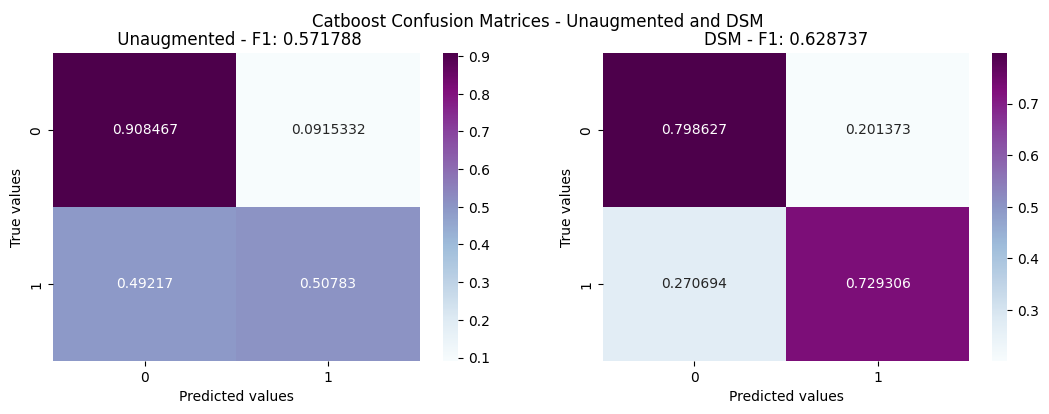

In [28]:
# Building confusion matrices sub-plots

catboost_fig, axes= plt.subplots(1,2, figsize=(13,4))
axes = axes.flatten()
catboost_fig.suptitle('Catboost Confusion Matrices - Unaugmented and DSM \n')

#unaugmented
cf_matrix_plot(y_test_encoded, unaug_catboost_pred, axes[0])
axes[0].set_title(f"\n Unaugmented - F1: {round(f1_score(y_test_encoded, unaug_catboost_pred) , 6)}")
axes[0].set_ylabel('True values')
axes[0].set_xlabel('Predicted values')

#DSM
cf_matrix_plot(y_test_encoded, DSM_catboost_pred, axes[1])
axes[1].set_title(f"DSM - F1: {round(f1_score(y_test_encoded, DSM_catboost_pred) , 6)}")
axes[1].set_ylabel('True values')
axes[1].set_xlabel('Predicted values')

unaug_fig.tight_layout()
plt.savefig('unaug_DSM_confusion_matrices_accomp.jpeg')
plt.show()